# Import packages

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from queue import Queue
%matplotlib inline

# 1. Camera Calibration & Distortion correction
In the "old_version_with_output/Lane_detection_opencv" notebook we didn't make this step and we get output fail to detect curved lanes accurately, and was not robust to obstructions and shadows so we cann't measure the curve in accurate direction.So we read about this step and why we need it! and we read that the Camera lenses distort incoming light to focus it on the camera sensor. Although this is very useful in allowing us to capture images of our environment, they often end up distorting light slightly inaccurately. This can result in inaccurate measurements in computer vision applications. so , we need to correct this to get more improvement.so how we can do this?..you can calibrate your image against a known object, and generate a distortion model which accounts for lens distortions. This object is often an asymmetric checkerboard.The steps to do that: We begin by converting the image to grayscale, then applying the cv2.findChessboardCorners() function. We already know that this chessboard is a 2 dimensional object with exclusively straight lines, so we can apply some transformations to the detected corners to align them properly. I used the cv2.CalibrateCamera() to get the distortion coefficients and the camera matrix. The camera has been calibrated!You can then use cv2.undistort() to correct the rest of your input data.

# 1.1 Loading Chessboard Images for Calibration

Distorted Chess Board Images


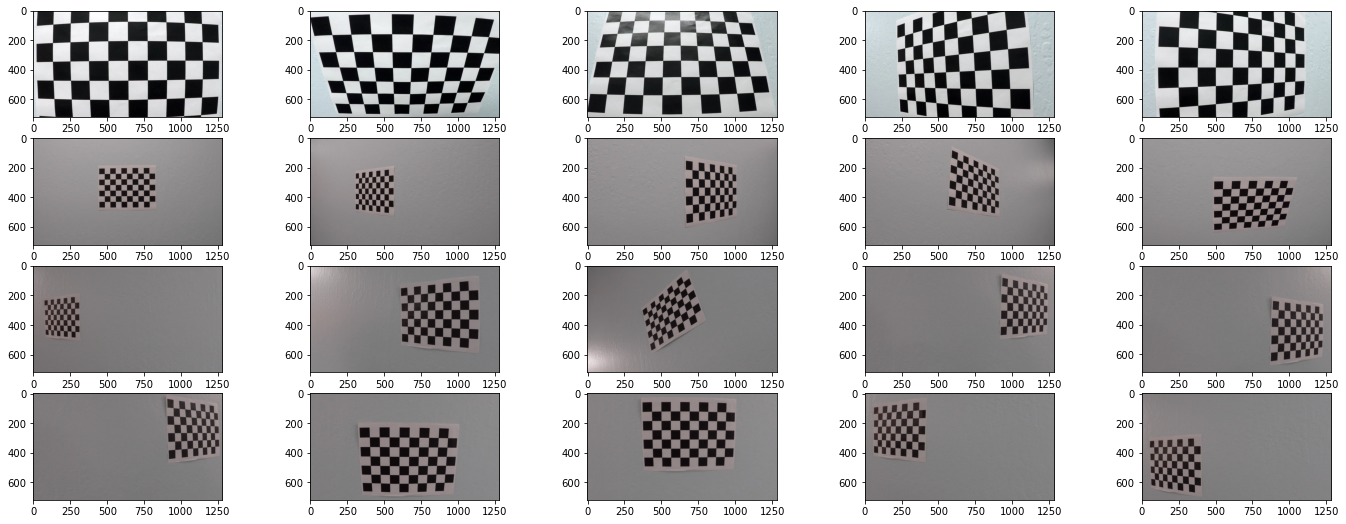

In [3]:
f,axes= plt.subplots(4,5, figsize=(24,9))
row=0
col=0
distorted=[]
print("Distorted Chess Board Images")
for i in range(20):
    image= cv2.imread("Project_data/camera_cal/calibration"+str(i+1)+".jpg")
    distorted.append(image)
    axes[row,col].imshow(image)
    col+=1
    if(col==5):
        col=0
        row+=1

# 1.2 find Chessboard Corners

Corners plotted Images


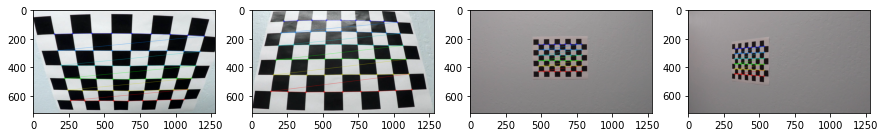

In [4]:
f,axes= plt.subplots(1,4, figsize=(15,15))
print("Corners plotted Images")
row=0
nx=9
ny=6
objpoints=[]
imgpoints=[]
objp=np.zeros((nx*ny,3),np.float32)
objp[:,:2]= np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for image in distorted:
    
    gray= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, corners= cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if(ret):
        objpoints.append(objp)
        imgpoints.append(corners)
        if row>3:
            continue
        cv2.drawChessboardCorners(image,(nx,ny), corners, ret)
        axes[row].imshow(image)
        row+=1

# 1.3 Calibrate Camera

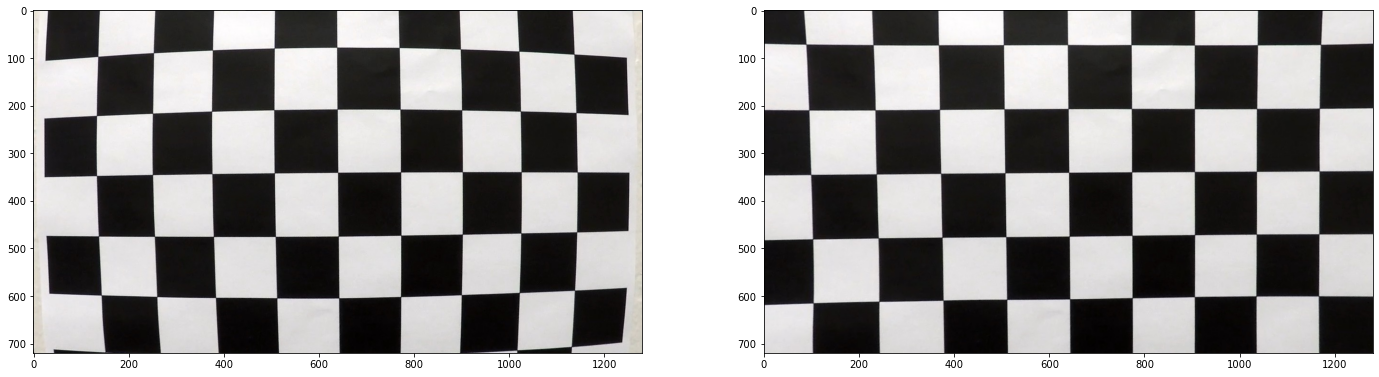

In [5]:
image_test= cv2.cvtColor(cv2.imread("Project_data/camera_cal/calibration1.jpg"),cv2.COLOR_BGR2RGB)
y=image_test.shape[0]
x=image_test.shape[1]
_,mtx,dist,_,_= cv2.calibrateCamera(objpoints, imgpoints,(y,x),None,None)
undistorted_image= cv2.undistort(image_test,mtx,dist, None, mtx)
f,axes= plt.subplots(1,2, figsize=(24,9))
axes[0].imshow(image_test)
axes[1].imshow(undistorted_image)

# 1.4 Undistortion

Distortion correction on test images


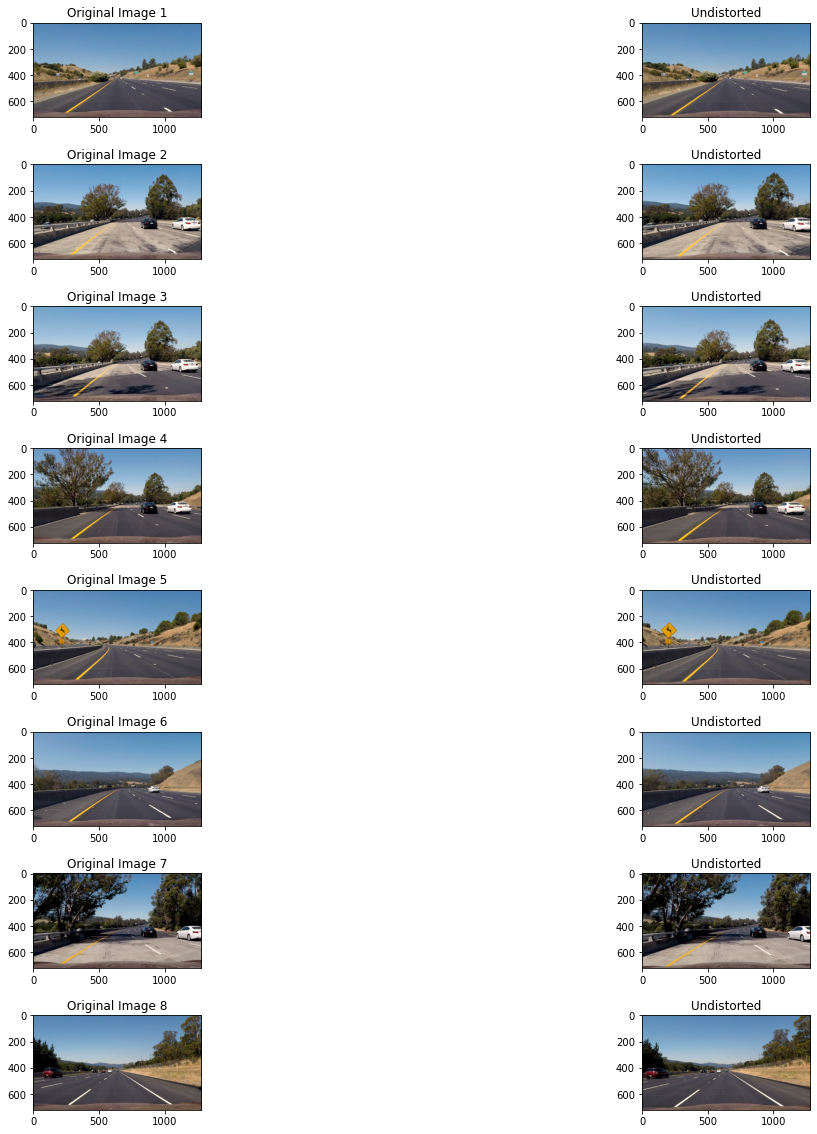

In [35]:
image_test1= cv2.imread("Project_data/test_images/straight_lines1.jpg")
image_test2= cv2.imread("Project_data/test_images/test1.jpg")
image_test3= cv2.imread("Project_data/test_images/test4.jpg")
image_test4= cv2.imread("Project_data/test_images/test6.jpg")
image_test5= cv2.imread("Project_data/test_images/test2.jpg")
image_test6= cv2.imread("Project_data/test_images/test3.jpg")
image_test7= cv2.imread("Project_data/test_images/test5.jpg")
image_test8=cv2.imread("Project_data/test_images/straight_lines2.jpg")
test_images=[image_test1,image_test2,image_test3,image_test4,image_test5,image_test6,image_test7,image_test8]
row=0
f,axes= plt.subplots(len(test_images),2, figsize=(20,20))
f.subplots_adjust(hspace=0.5)
print("Distortion correction on test images")
def undistort(img):
    return cv2.undistort(img,mtx,dist, None, mtx)

for image in test_images:
    image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    y=image.shape[0]
    x=image.shape[1]
    axes[row,0].set_title('Original Image '+str(row+1))
    axes[row,0].imshow(image)
    undistorted_image= undistort(image)
    axes[row,1].imshow(undistorted_image)
    axes[row,1].set_title('Undistorted')
    row+=1

# 2. Perspective transform

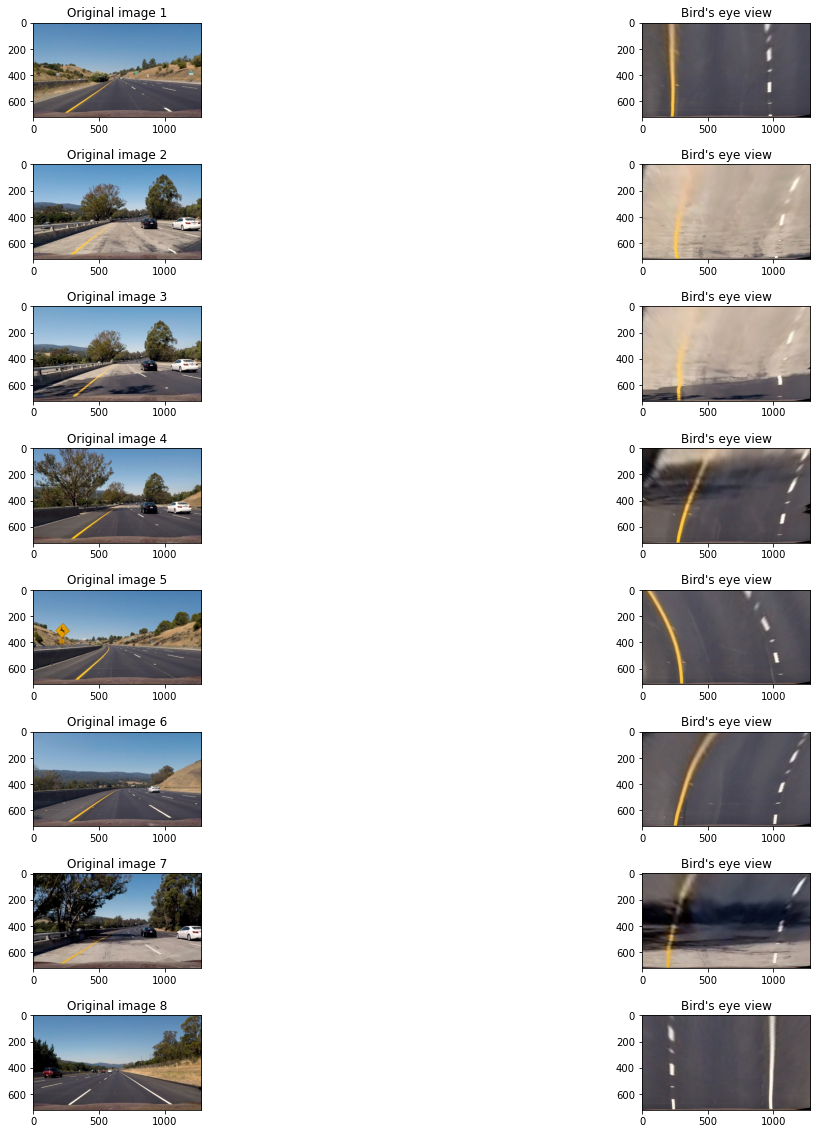

In [36]:
offset=200
height, width= image_test1.shape[0], image_test1.shape[1]
src=np.float32([(593,450),(700,450),(1200,700),(200,700)])
dst=np.float32([(offset,0),(width-offset,0),(width-offset,height),(offset,height)])
def warp_image(img):
    img_size = (img.shape[1], img.shape[0])
    M= cv2.getPerspectiveTransform(src, dst) 
    inv= cv2.getPerspectiveTransform(dst, src)
    warped= cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,inv

def reverse_warping(img,M):
    img_size = (img.shape[1], img.shape[0])
    unwarped= cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

f,axes= plt.subplots(len(test_images),2, figsize=(20,20))
f.subplots_adjust(hspace=0.5)
row=0
Unwarped_images=[]

def ConvertBGRtoRGB(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for image in test_images:
    image= ConvertBGRtoRGB(image)
    unwarped_image,inv= warp_image(image)
    Unwarped_images.append(unwarped_image)
    y=image.shape[0]
    x=image.shape[1]
    axes[row,0].imshow(image)
    axes[row,0].set_title('Original image '+str(row+1))
    axes[row,1].imshow(unwarped_image)
    axes[row,1].set_title("Bird's eye view")
    row+=1    

# 2.1 Test on various colorSpaces

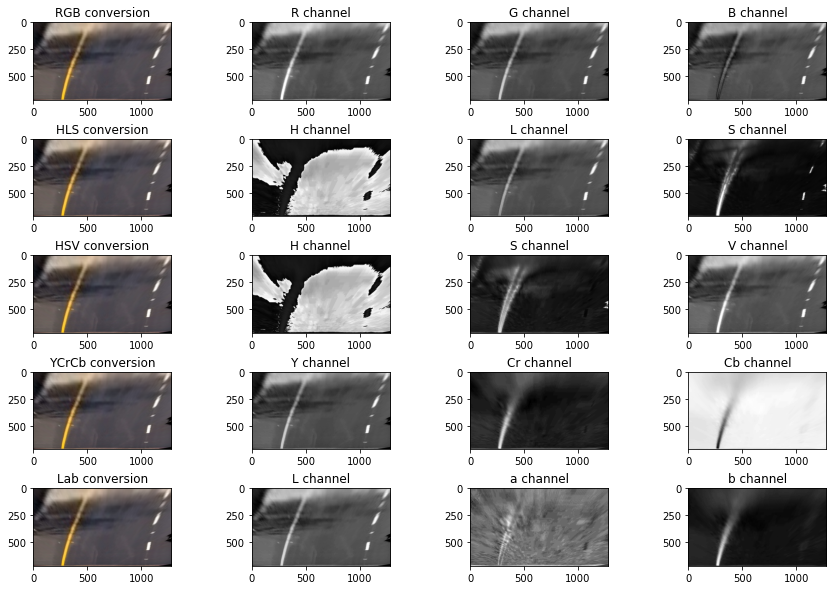

In [37]:
row=0
sample_unwarped_image=Unwarped_images[3] ##  test4.jpg : This image has dark and bright portions and will be good to observe
titles=[['R','G','B'],['H','L','S'],['H','S','V'],['Y','Cr','Cb'],['L','a','b']]
color_spaces=[cv2.COLOR_RGB2HLS,cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2YCrCb, cv2.COLOR_RGB2Lab]
f,axes= plt.subplots(len(color_spaces)+1,4, figsize=(15,10))
f.subplots_adjust(hspace =0.5)
colorspace= None
for index in range(len(color_spaces)+1):
    if(index==0):
        colorspace= sample_unwarped_image
    else:
        colorspace= cv2.cvtColor(sample_unwarped_image,color_spaces[index-1])
    axes[index,0].imshow(sample_unwarped_image)
    axes[index,0].set_title(''.join(titles[index]) +' conversion')
    for channel in range(3):
        this_channel= colorspace[:,:,channel]
        axes[index,channel+1].imshow(this_channel,cmap='gray')
        axes[index,channel+1].set_title(titles[index][channel]+' channel')

Out of the all the channels visualized above, R channel from RGB, S channel from HSV or HLS, Y channel from YCrCb and L channel from Lab colorspace look promising and are able to identify the lane lines easily, which are too bright to identify in the original image itself.


In [9]:
def channelwise_thresholding(image,thresh):
    image = image*(255/np.max(image))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(image)
    binary_output[(image > thresh[0]) & (image <= thresh[1])] = 1
    return binary_output

# 2.2 Test with selected color channels (Y,Cr,L and S)

In [10]:
def Custom_channel_converter(img):
    
    img1=cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)[:,:,0] # Y channel
    img2=cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)[:,:,1] #Cr channel
    img3=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,1] #L channel
    img4=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,2] #S channel
    return img1, img2, img3, img4

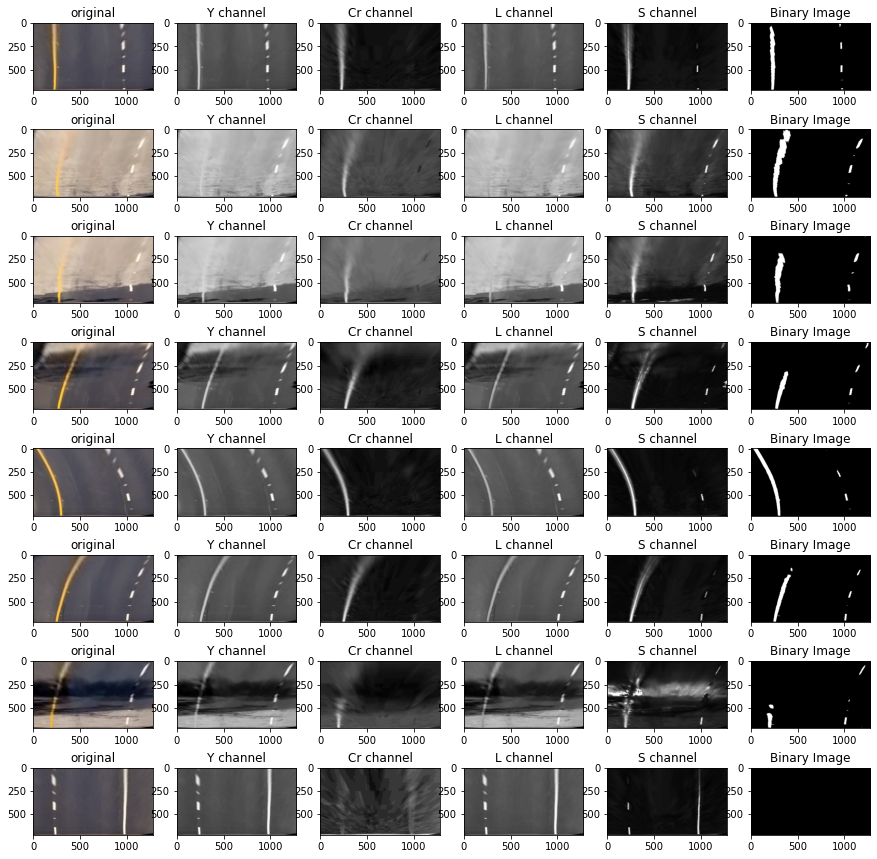

In [38]:
f,axes= plt.subplots(len(Unwarped_images),6, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0

for image in Unwarped_images:
    imgY, imgCr, imgL, imgS= Custom_channel_converter(image)
    axes[row,0].imshow(image)
    axes[row,0].set_title('original')
    axes[row,1].imshow(imgY, cmap='gray')
    axes[row,1].set_title('Y channel')
    axes[row,2].imshow(imgCr, cmap='gray')
    axes[row,2].set_title('Cr channel')
    axes[row,3].imshow(imgL, cmap='gray')
    axes[row,3].set_title('L channel')
    axes[row,4].imshow(imgS, cmap='gray')
    axes[row,4].set_title('S channel')
    Ybinary= channelwise_thresholding(imgY,(215,255))
    Crbinary= channelwise_thresholding(imgCr,(215,255))
    Lbinary= channelwise_thresholding(imgL,(215,255))
    Sbinary= channelwise_thresholding(imgS,(215,255))
    combinedImage= np.zeros_like(Ybinary)
    combinedImage[(Crbinary==1)|(Ybinary==1)|((Lbinary==1)&(Sbinary==1))]=1
#     ((Sbinary==1)&(Hbinary==0))|(Crbinary==1)
    axes[row,5].imshow(combinedImage, cmap='gray')
    axes[row,5].set_title('Binary Image')
    row+=1

# 3. Sobel x and y

In [12]:
def sobel_image(img, orient='x', thresh_min=0, thresh_max=255, convert=True):
    
    
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel=None
    if(orient=='x'):
        sobel= cv2.Sobel(gray, cv2.CV_64F, 1,0)
    else:
        sobel= cv2.Sobel(gray, cv2.CV_64F, 0,1)
    
    sobel_abs= np.absolute(sobel)
    sobel_8bit= np.uint8(255* sobel_abs/np.max(sobel_abs))
    binary_output= np.zeros_like(sobel_8bit) 
    binary_output[(sobel_8bit>=thresh_min) & (thresh_max>=sobel_8bit)]=1
    
    return binary_output

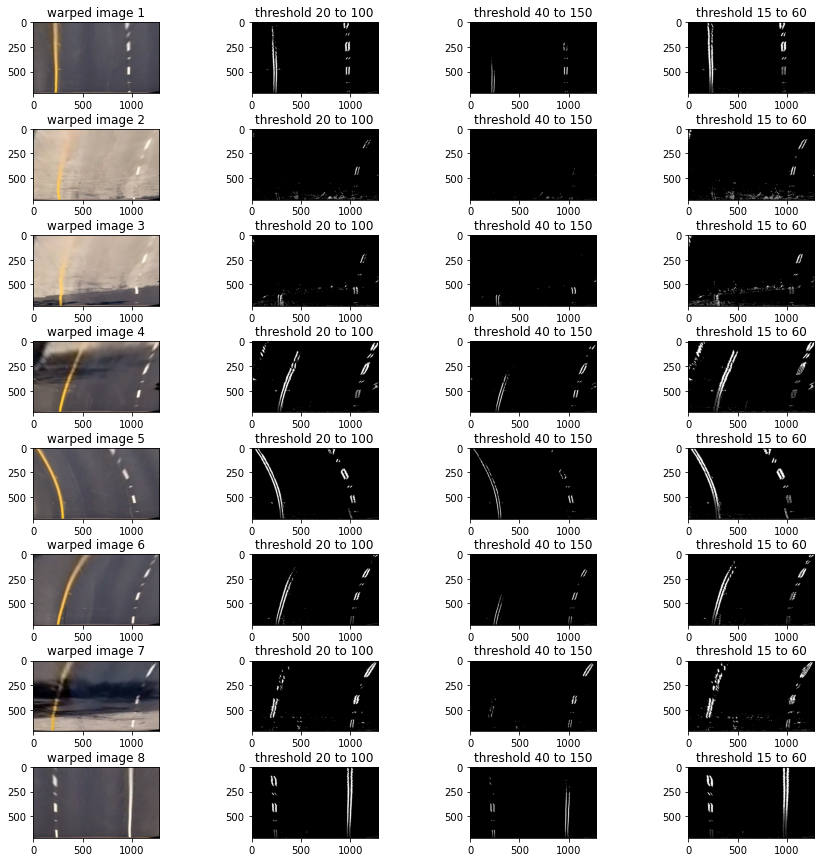

In [39]:
threshVal= [(20,100),(40,150),(15,60)]

f,axes= plt.subplots(len(Unwarped_images),4, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
    #image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    sobel_applied_image1= sobel_image(image, 'x', threshVal[0][0], threshVal[0][1], True)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshVal[0][0])+' to '+str(threshVal[0][1]))
    sobel_applied_image2= sobel_image(image, 'x', threshVal[1][0], threshVal[1][1], True)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshVal[1][0])+' to '+str(threshVal[1][1]))
    sobel_applied_image3= sobel_image(image, 'x', threshVal[2][0], threshVal[2][1], True)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshVal[2][0])+' to '+str(threshVal[2][1]))
    row+=1

In image 2 and 3, the left lane line is completely getting misidentified. Sobel is identifying road edge as the lane line. This is due to the low contrast between lane line and the bright road in these two images.

# 3.1 Sobel magnitude

In [40]:
def sobel_mag(img, thresh, convert=True):
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1,0)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0,1)
    
    mag= (sobelx**2+ sobely**2)**(0.5)
    
    sobel_mag_8bit= np.uint8(255* mag/np.max(mag))
    binary_output= np.zeros_like(sobel_mag_8bit) 
    binary_output[(sobel_mag_8bit>=thresh[0]) & (thresh[1]>=sobel_mag_8bit)]=1
    
    return binary_output

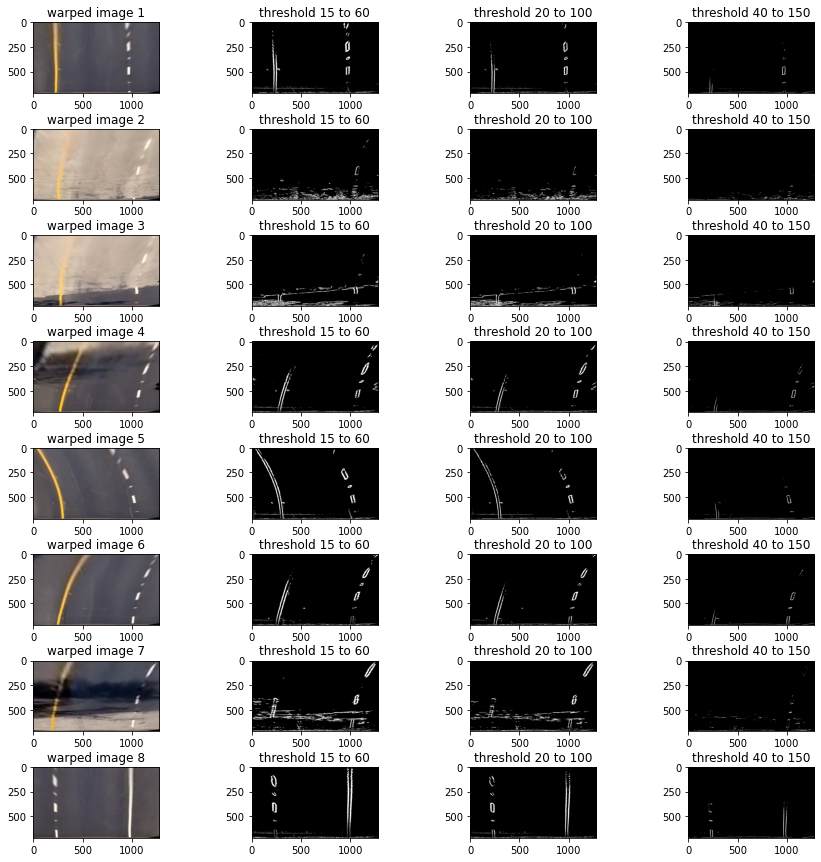

In [41]:
threshMag= [(15,60),(20,100),(40,150)]

f,axes= plt.subplots(len(Unwarped_images),4, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
#     convert=False
#     image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    sobel_applied_image1= sobel_mag(image, threshMag[0],convert)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshMag[0][0])+' to '+str(threshMag[0][1]))
    sobel_applied_image2= sobel_mag(image,  threshMag[1],convert)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshMag[1][0])+' to '+str(threshMag[1][1]))
    sobel_applied_image3= sobel_mag(image,  threshMag[2],convert)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshMag[2][0])+' to '+str(threshMag[2][1]))
    row+=1

I can't see any improvement in lane detection using sobel magnitude also. Sobel is not able to detect low contrast lane lines and hence will completely fail in bright road conditions.

# 3.2 Sobel Gradient

In [16]:
def sobel_gradient_image(img, thresh=(0, np.pi/2), convert=True):
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=15)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=15)
    
    abs_sobelx= np.absolute(sobelx)
    abs_sobely= np.absolute(sobely)
    
    grad= np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output=np.zeros_like(grad)
    binary_output[(grad>thresh[0])&(grad<thresh[1])]=1
    return binary_output

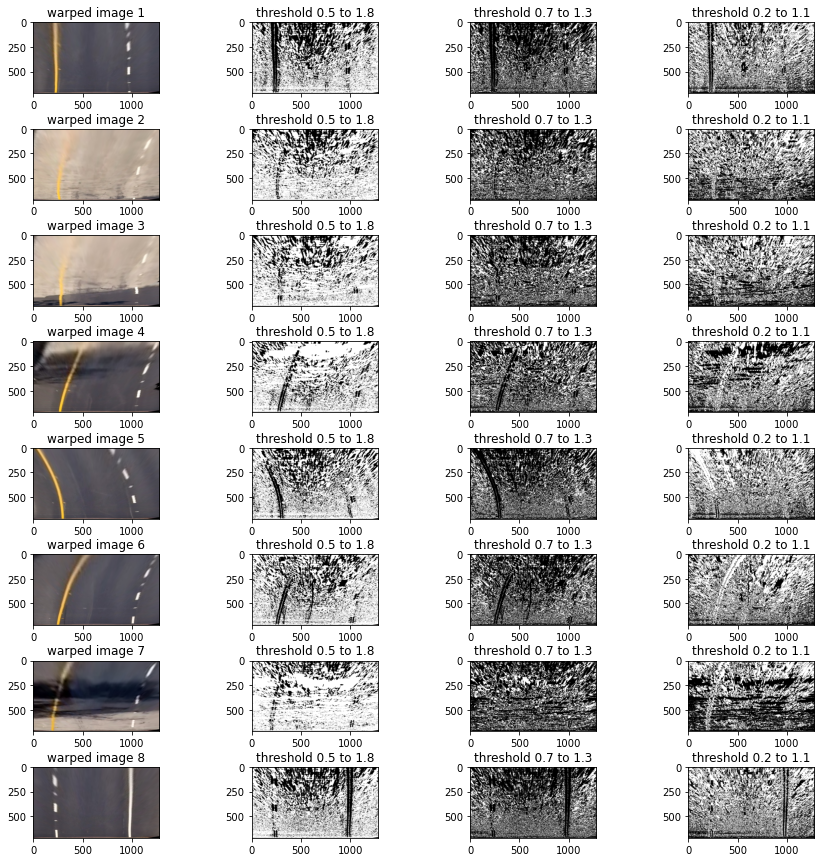

In [42]:
threshGrad= [(0.5,1.8),(0.7,1.3),(0.2,1.1)]

f,axes= plt.subplots(len(Unwarped_images),4, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
#     image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
#     convert=False
    sobel_applied_image1= sobel_gradient_image(image, threshGrad[0], convert)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshGrad[0][0])+' to '+str(threshGrad[0][1]))
    sobel_applied_image2= sobel_gradient_image(image,  threshGrad[1], convert)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshGrad[1][0])+' to '+str(threshGrad[1][1]))
    sobel_applied_image3= sobel_gradient_image(image,  threshGrad[2], convert)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshGrad[2][0])+' to '+str(threshGrad[2][1]))
    row+=1

Gradient sobel in itself doesn't looks good enough to detect lane lines. Also there is lot of noise in the images. I'll further try to combine the sobel techniques along with the color channels to detect lane lines better and to suppress the detection of road edges in bright as well as dark conditions.

# 3.3 Combining Sobel with appropriate channels

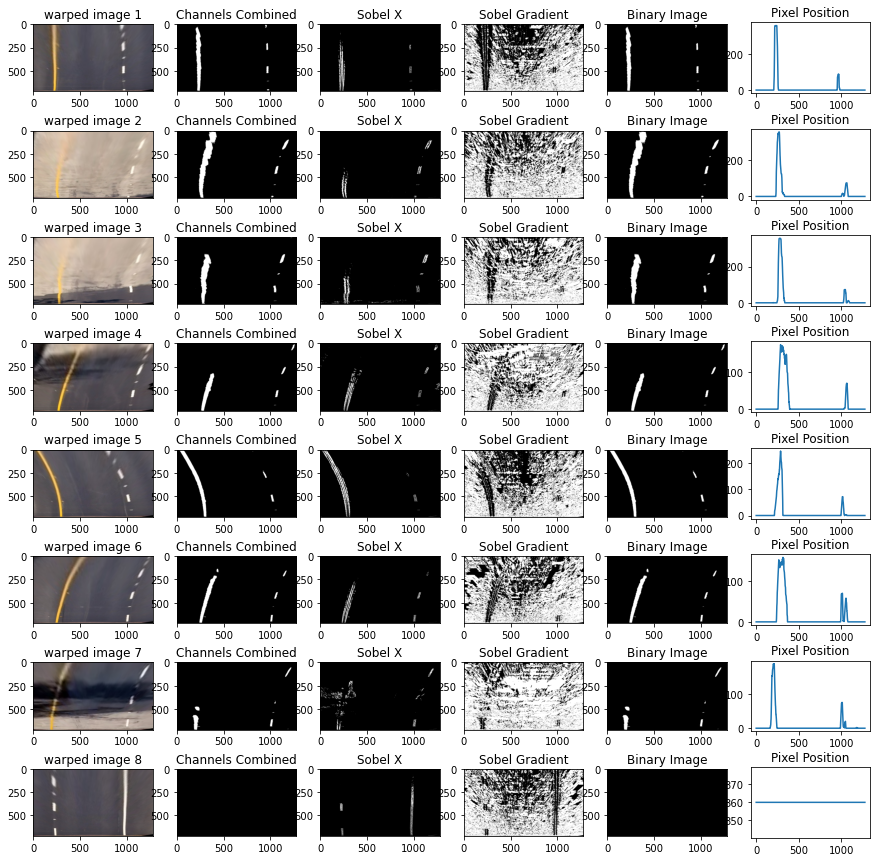

In [43]:
f,axes= plt.subplots(len(Unwarped_images),6, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
Processed_Image=[]
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
    
    #image= cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)[:,:,1]
    imgY, imgCr, imgb, imgS= Custom_channel_converter(image)
    
    Ybinary= channelwise_thresholding(imgY,(215,255))
    Crbinary= channelwise_thresholding(imgCr,(215,255))
    Lbinary= channelwise_thresholding(imgb,(215,255))
    Sbinary= channelwise_thresholding(imgS,(200,255))
    combined1 = np.zeros_like(imgY)
    
#     sobel_mag_image= sobel_mag(image_S_channel, (15,60), False)
    combined1[(Crbinary==1)|(Ybinary==1)|((Lbinary==1)&(Sbinary==1))]=1
    
    axes[row,1].imshow(combined1,cmap='gray')
    axes[row,1].set_title('Channels Combined')

    image_S_channel= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    convert=False

    sobel_image1= sobel_image(image_S_channel,'x', 15,60, convert)
    axes[row,2].imshow(sobel_image1,cmap='gray')
    axes[row,2].set_title('Sobel X')
#     sobel_grad_image= sobel_gradient_image(image, (0.3,2.0),convert)
    sobel_grad_image= sobel_gradient_image(image_S_channel,  (0.5,1.8), convert)
    axes[row,3].imshow(sobel_grad_image,cmap='gray')
    axes[row,3].set_title('Sobel Gradient')
    combined = np.zeros_like(sobel_image1)
#     combined[((sobel_image1 == 1) & (sobel_grad_image == 0))|(Schannel_binary==1)] = 1
    combined[(Crbinary==1)|(Ybinary==1)|((Lbinary==1)&(Sbinary==1))] = 1
    
    axes[row,4].imshow(combined,cmap='gray')
    axes[row,4].set_title('Binary Image')
    Processed_Image.append(combined)
    histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
    axes[row,5].plot(histogram)
    axes[row,5].set_title('Pixel Position')  
    
    row+=1

# 4. Fitting line on detected lanes and plotting windows

In [44]:
fit_prev_left=[]
fit_prev_right=[]
fit_sum_left=0
fit_sum_right=0
def Plot_line(binary_warped, smoothen=False,prevFrameCount=6 ): #used Udacity's code to plot the lines and windows over lanes 
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lane_width= abs(rightx_base-leftx_base)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
     # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(smoothen):
        global fit_prev_left
        global fit_prev_right
        global fit_sum_left
        global fit_sum_right
        if(len(fit_prev_left)>prevFrameCount):
            fit_sum_left-= fit_prev_left.pop(0)
            fit_sum_right-= fit_prev_right.pop(0)

        fit_prev_left.append(left_fit)
        fit_prev_right.append(right_fit)
        fit_sum_left+=left_fit
        fit_sum_right+= right_fit

        no_of_fit_values=len(fit_prev_left) 
        left_fit= fit_sum_left/no_of_fit_values
        right_fit= fit_sum_right/no_of_fit_values
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    window_img = np.zeros_like(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return out_img, result, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width


# Testing the Plot lines function on warped images

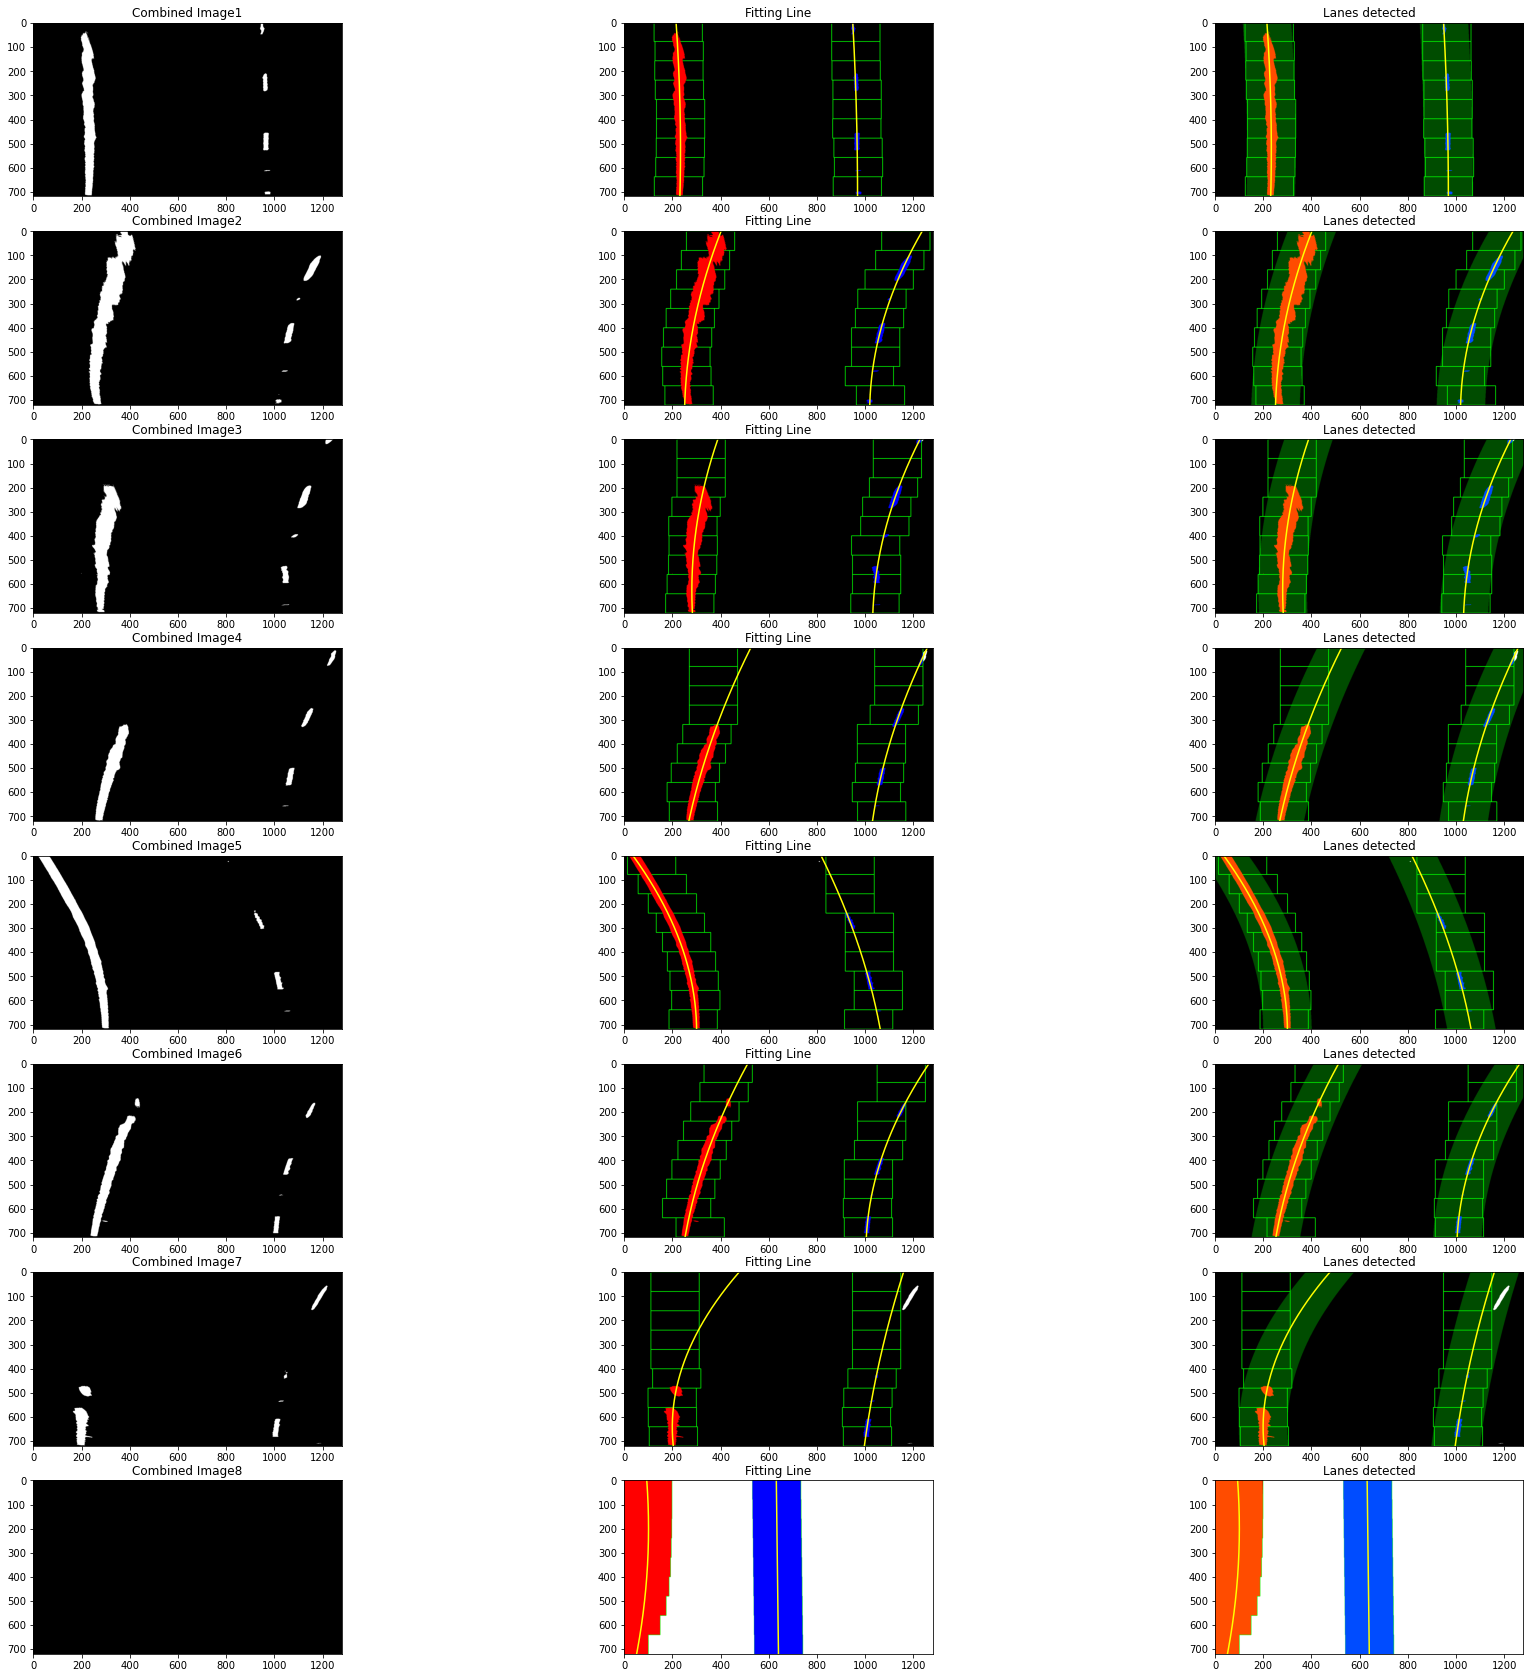

In [45]:
f,axes= plt.subplots(len(Unwarped_images),3, figsize=(30,30))
f.subplots_adjust(hspace =0.2, wspace=0.2)
row=0

for image in Processed_Image:
    global fit_prev_left
    global fit_prev_right
    global fit_sum_left
    global fit_sum_right
    fit_prev_left=[]
    fit_prev_right=[]
    fit_sum_left=0
    fit_sum_right=0
    axes[row,0].imshow(image,cmap='gray')
    axes[row,0].set_title('Combined Image'+str(row+1))
    

    out_img,out_img1, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width= Plot_line(image)
    axes[row,1].imshow(out_img)
    axes[row,1].plot(left_fitx, ploty, color='yellow')
    axes[row,1].plot(right_fitx, ploty, color='yellow')
    axes[row,1].set_title('Fitting Line')
    
    axes[row,2].imshow(out_img1)
    axes[row,2].plot(left_fitx, ploty, color='yellow')
    axes[row,2].plot(right_fitx, ploty, color='yellow')
    axes[row,2].set_title("Lanes detected")
    
    row+=1

# Drawing the center green Lane

In [24]:
def draw_lane(original_img, Combined_img, left_fitx, right_fitx, M):
    new_img = np.copy(original_img)

    warp_zero = np.zeros_like(Combined_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = Combined_img.shape
    ploty = np.linspace(0, h-1, num=h)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)

    return color_warp, new_img

# Caclulating the distance of car from center


# Caclulating the direction of car from center

# Plotting details on the Image


# Calculating Radius of curvature, position, direction and speed of car

# Pipeline

In [29]:
def Lane_pipeline(img,smoothen,prevFrameCount):
    undistorted_image= undistort(img)
    warped_image,M= warp_image(undistorted_image)
    image_S_channel= cv2.cvtColor(warped_image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    imgY, imgCr, imgb, imgS= Custom_channel_converter(warped_image)
    
    Ybinary= channelwise_thresholding(imgY,(215,255))
    Crbinary= channelwise_thresholding(imgCr,(215,255))
    Lbinary= channelwise_thresholding(imgb,(215,255))
    Sbinary= channelwise_thresholding(imgS,(200,255))
    combined = np.zeros_like(imgY)
    
#     sobel_mag_image= sobel_mag(image_S_channel, (15,60), False)
    sobel_image1= sobel_image(image_S_channel,'x', 15,60, False)
    sobel_grad_image= sobel_gradient_image(image_S_channel,  (0.5,1.8), False)
    combined[(Crbinary==1)|(Ybinary==1)|((Lbinary==1)&(Sbinary==1))] = 1
#     |((sobel_image1==1) & (sobel_grad_image==1))
#     plt.imshow(combined)
#     combined[]=1
    
#     |((sobel_image1==1)&(sobel_grad_image==1))
#     ((sobel_mag_image == 1) & (sobel_grad_image == 0))
    
#     out_img,out_img1, left_fitx,right_fitx,ploty,left_curverad,right_curverad,center_dist= Plot_line(combined)
    out_img,out_img1, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width= Plot_line(combined,smoothen,prevFrameCount)
    curverad,center_dist,width_lane,lane_center_position= calc_radius_position(combined,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width)
    laneImage,new_img =draw_lane(img, combined, left_fitx, right_fitx, M)
    unwarped_image= reverse_warping(laneImage,M)
    laneImage = cv2.addWeighted(new_img, 1, unwarped_image, 0.5, 0)
    laneImage, copy = Plot_details(laneImage,curverad,center_dist,width_lane,lane_center_position)
    return img,out_img,out_img1,unwarped_image,laneImage,combined,copy

    

# Testing the pipeline on test images

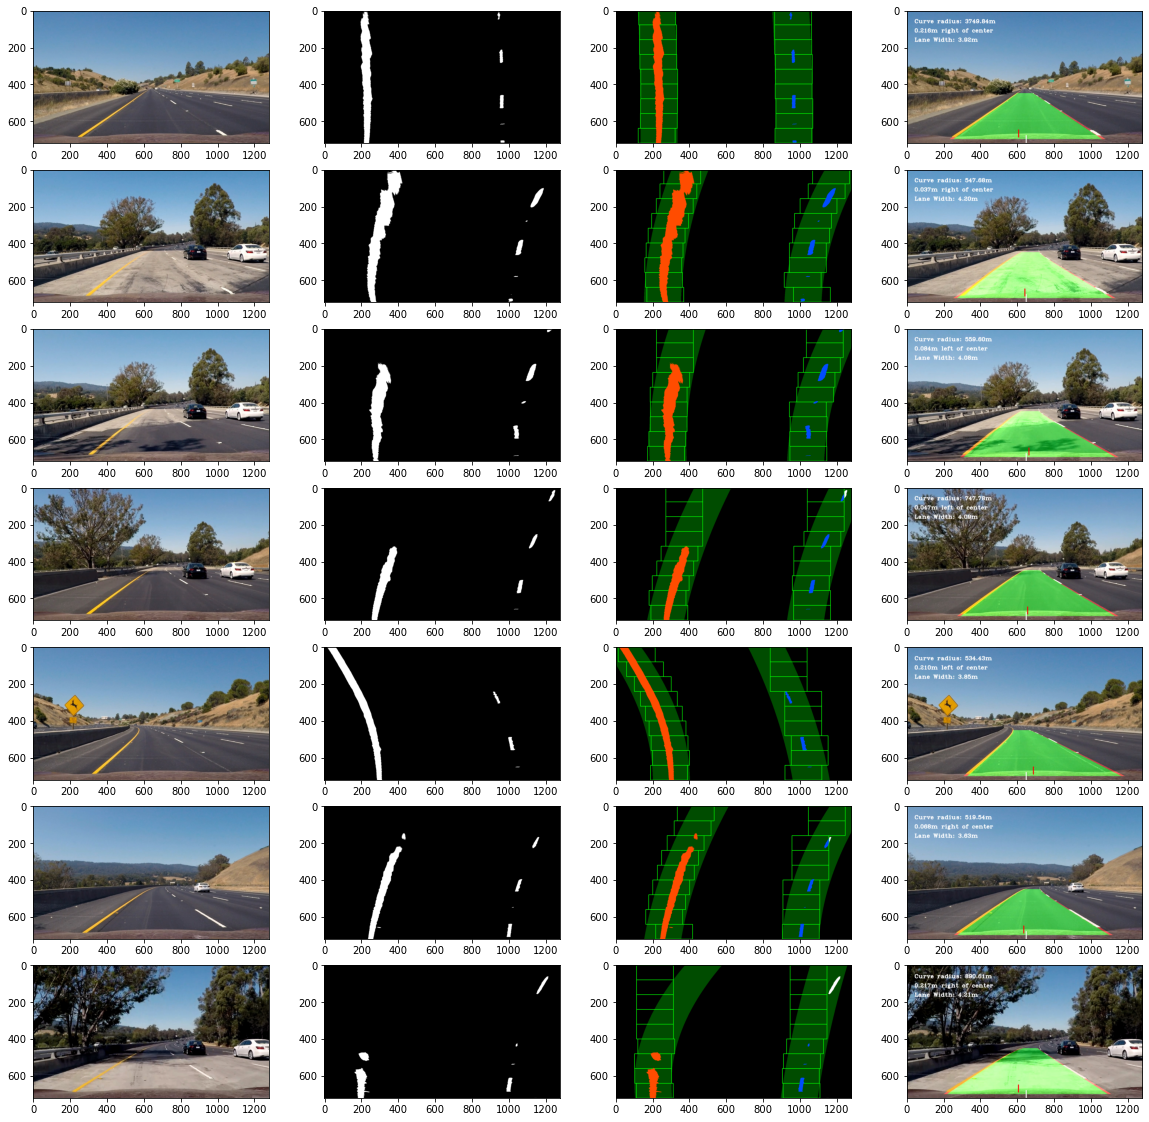

In [30]:
f,axes= plt.subplots(7,4, figsize=(20,20))
row=0

for index in range(7):
    global fit_prev_left
    global fit_prev_right
    global fit_sum_left
    global fit_sum_right
    global radius_sum
    global radius_values
    global center_distances
    global distanceSum
    fit_prev_left=[]
    fit_prev_right=[]
    fit_sum_left=0
    fit_sum_right=0
    radius_sum=0
    radius_values.queue.clear()
    center_distances.queue.clear()
    distanceSum=0
    
    image= test_images[index]
    image= ConvertBGRtoRGB(image)
    rgb_image,out_img,out_img1,unwarped_image,laneImage,combined,copy= Lane_pipeline(image, False,0)
    
    axes[row,0].imshow(rgb_image)
    axes[row,1].imshow(combined, cmap='gray')
    axes[row,2].imshow(out_img1)
    axes[row,3].imshow(laneImage)
    row+=1

# Function calling pipeline for Video Creation

In [31]:
def CallPipeline(image):
    smoothen= True
    prevFrameCount=4
    rgb_image,out_img,out_img1,unwarped_image,laneImage,combined,data_copy= Lane_pipeline(image,smoothen,prevFrameCount)

    out_image = np.zeros((720,1280,3), dtype=np.uint8)
    
    #stacking up various images in one output Image
    out_image[0:720,0:1280,:] = cv2.resize(laneImage,(1280,720)) #top-left
    out_image[20:190,960:1260,:] = cv2.resize(np.dstack((combined*255, combined*255, combined*255)),(300,170))#side Panel
    out_image[210:380,960:1260,:] = cv2.resize(out_img,(300,170))#side Panel
#     out_image[400:570,960:1260,:] = cv2.resize(data_copy,(300,170))#bottom-left
    return out_image

# Video Processing

In [34]:
video_output1 = 'project_video_output3.mp4'
video_input1 = VideoFileClip('Project_data/harder_challenge_video.mp4')#.subclip(20,25)
processed_video = video_input1.fl_image(CallPipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output3.mp4.
Moviepy - Writing video project_video_output3.mp4



t:  69%|██████▉   | 828/1199 [10:10<04:47,  1.29it/s, now=None]

TypeError: expected non-empty vector for x